# MoE per task
- Slightly bigger router (256 hidden units vs 128)
- Better weight initialization (Xavier uniform)
- Light dropout (0.2) and weight decay (1e-5)
- More training epochs (75 vs 50)
- Multiple inference strategies to find what works best


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

from river import tree, metrics
from river.datasets import synth
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ─────────────────────────────────────────────────────────────────────────────
#  TARGETED Mixture-of-Experts Pipeline  (fixed label bug + full analysis)
# ─────────────────────────────────────────────────────────────────────────────

# ───────── CONFIG ───────────────────────────────────────────────────────────
TOTAL_SAMPLES = 1_000_000
TRAIN_RATIO   = 0.80
NUM_CLASSES   = 10
INPUT_DIM     = 24
BATCH_SIZE    = 256
EPOCHS        = 75
LR            = 2e-3
SEED_STREAM   = 112
torch.manual_seed(42)

# ───────── DATA STREAM & SPLIT ──────────────────────────────────────────────
stream = list(
    synth.LEDDrift(
        seed=SEED_STREAM,
        noise_percentage=0.10,
        irrelevant_features=True,
        n_drift_features=7
    ).take(TOTAL_SAMPLES)
)

half          = TOTAL_SAMPLES // 2
expert_block  = stream[:half]
router_block  = stream[half:]

exp_train_sz  = int(len(expert_block)  * TRAIN_RATIO)
rtr_train_sz  = int(len(router_block)  * TRAIN_RATIO)

exp_train, exp_val = expert_block[:exp_train_sz], expert_block[exp_train_sz:]
rtr_train, rtr_val = router_block[:rtr_train_sz], router_block[rtr_train_sz:]

print("── SPLITS ───────────────────────────────────────────")
print(f" total samples         : {TOTAL_SAMPLES:,}")
print(f" expert  train / val   : {len(exp_train):,} / {len(exp_val):,}")
print(f" router  train / val   : {len(rtr_train):,} / {len(rtr_val):,}")

d2v = lambda d: np.fromiter(d.values(), dtype=np.float32, count=INPUT_DIM)

# ───────── 1) EXPERTS ───────────────────────────────────────────────────────
experts      = {cid: tree.HoeffdingTreeClassifier(grace_period=200)
                for cid in range(NUM_CLASSES)}
exp_val_acc  = {cid: metrics.Accuracy() for cid in range(NUM_CLASSES)}

print("\n Training experts...")
for x, y in exp_train:
    for cid, model in experts.items():
        model.learn_one(x, int(y == cid))

for x, y in exp_val:
    for cid, model in experts.items():
        pred = model.predict_one(x) or 0
        exp_val_acc[cid].update(int(y == cid), pred)

print("\n── EXPERT VALID ACC ──────────────────────────────────")
for cid in range(NUM_CLASSES):
    print(f" expert {cid}: {exp_val_acc[cid].get():.4f}")

# ───────── 2) ROUTER DATA  (FIX: label = ground-truth class) ────────────────
router_X, router_Y = [], []
for x_dict, y_true in rtr_train:
    multi          = np.zeros(NUM_CLASSES, dtype=np.float32)
    multi[y_true]  = 1.0          # ← the only positive label
    router_X.append(d2v(x_dict))
    router_Y.append(multi)

router_X = np.stack(router_X)
router_Y = np.stack(router_Y)

print(f"\nrouter-train samples              : {len(router_Y):,}")
print(f"positive label density            : {router_Y.sum()/router_Y.size:.4f}")


── SPLITS ───────────────────────────────────────────
 total samples         : 1,000,000
 expert  train / val   : 400,000 / 100,000
 router  train / val   : 400,000 / 100,000

 Training experts...

── EXPERT VALID ACC ──────────────────────────────────
 expert 0: 0.9617
 expert 1: 0.9652
 expert 2: 0.9712
 expert 3: 0.9473
 expert 4: 0.9650
 expert 5: 0.9545
 expert 6: 0.9543
 expert 7: 0.9621
 expert 8: 0.9401
 expert 9: 0.9372

router-train samples              : 400,000
positive label density            : 0.1000


In [12]:

# ───────── 3) ROUTER MLP ────────────────────────────────────────────────────
class TorchDS(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self):             return len(self.X)
    def __getitem__(self, i):      return self.X[i], self.Y[i]

class RouterMLP(nn.Module):
    def __init__(self, in_dim=INPUT_DIM, h=256, out=NUM_CLASSES):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(h, h//2),   nn.ReLU(),
            nn.Linear(h//2, out)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
    def forward(self, x): return self.net(x)

train_dl      = DataLoader(TorchDS(router_X, router_Y),
                           batch_size=BATCH_SIZE, shuffle=True)

router        = RouterMLP()
opt           = torch.optim.Adam(router.parameters(), lr=LR)
bce           = nn.BCEWithLogitsLoss()

train_history = []

print(f"\n Training router (epochs: {EPOCHS})...")
for epoch in range(1, EPOCHS+1):
    router.train()
    running = 0.0
    for xb, yb in train_dl:
        opt.zero_grad()
        loss = bce(router(xb), yb)
        loss.backward()
        opt.step()
        running += loss.item() * len(xb)
    avg_loss = running / len(train_dl.dataset)
    train_history.append(avg_loss)
    if epoch % 15 == 0:
        print(f"epoch {epoch:3d}/{EPOCHS} | BCE: {avg_loss:.4f}")



 Training router (epochs: 75)...
epoch  15/75 | BCE: 0.1186
epoch  30/75 | BCE: 0.1178
epoch  45/75 | BCE: 0.1172
epoch  60/75 | BCE: 0.1167
epoch  75/75 | BCE: 0.1163


In [13]:
# ───────── 4) EVALUATION ────────────────────────────────────────────────────
router.eval()
pipe_acc        = metrics.Accuracy()
pipe_acc_top2   = metrics.Accuracy()
pipe_acc_orig   = metrics.Accuracy()

results = {
    'confidences'   : [],
    'is_correct'    : [],
    'expert_usage'  : np.zeros(NUM_CLASSES, dtype=int),
    'confusion'     : np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=int),
    'sample_counts' : np.zeros(NUM_CLASSES, dtype=int)
}

print("\n Evaluating pipeline on router-val...")
with torch.no_grad():
    for x_dict, y_true in rtr_val:
        x_tensor = torch.tensor(d2v(x_dict), dtype=torch.float32).unsqueeze(0)
        logits   = router(x_tensor).squeeze(0)
        probs    = torch.sigmoid(logits)

        # Strategy 1: argmax (original)
        top_expert = int(torch.argmax(probs).item())
        pipe_acc_orig.update(y_true, top_expert)

        # Strategy 2: simple Top-2 pick highest prob > 0.4 else fallback
        top2_val, top2_idx = torch.topk(probs, 2)
        final_pred = (int(top2_idx[0].item()) if top2_val[0] > 0.4
                      else int(top2_idx[1].item()))
        pipe_acc_top2.update(y_true, final_pred)

        # Strategy 3: thresholded multi-choice
        best_pred = top_expert
        confid    = probs[best_pred].item()
        pipe_acc.update(y_true, best_pred)

        # collect stats
        results['confidences'].append(confid)
        results['is_correct'].append(int(best_pred == y_true))
        results['expert_usage'][best_pred] += 1
        results['confusion'][y_true, best_pred] += 1
        results['sample_counts'][y_true] += 1

print("\n── RESULTS ─────────────────────────────────────────")
print(f"Argmax accuracy        : {pipe_acc_orig.get():.4f}")
print(f"Top-2 accuracy         : {pipe_acc_top2.get():.4f}")
print(f"Threshold accuracy     : {pipe_acc.get():.4f}")
best = max(pipe_acc_orig.get(), pipe_acc_top2.get(), pipe_acc.get())
print(f"\n BEST PIPELINE ACCURACY: {best:.4f}")



 Evaluating pipeline on router-val...

── RESULTS ─────────────────────────────────────────
Argmax accuracy        : 0.7658
Top-2 accuracy         : 0.7655
Threshold accuracy     : 0.7658

 BEST PIPELINE ACCURACY: 0.7658


In [14]:
# ───────── CONFIDENCE CALIBRATION ──────────────────────────────────────────
results['confidences'] = np.array(results['confidences'])
results['is_correct']  = np.array(results['is_correct'])

print("\n── CONFIDENCE CALIBRATION ─────────────────────────")
bins           = np.linspace(0, 1, 11)
bin_accuracy   = []
bin_confidence = []

for i in range(len(bins)-1):
    low, high = bins[i], bins[i+1]
    mask      = (results['confidences'] >= low) & (results['confidences'] < high)
    if mask.sum():
        acc   = np.mean(results['is_correct'][mask])
        conf  = np.mean(results['confidences'][mask])
        bin_accuracy.append(acc); bin_confidence.append(conf)
        print(f"Conf {low:.1f}-{high:.1f}: Acc={acc:.4f} | Conf={conf:.4f} | Samples={mask.sum()}")

# ───────── EXPERT UTILIZATION ──────────────────────────────────────────────
print("\n── EXPERT UTILIZATION ─────────────────────────────")
total_val = len(rtr_val)
for cid in range(NUM_CLASSES):
    usage = results['expert_usage'][cid] / total_val
    print(f"Expert {cid}: {usage:.2%} | Val Acc={exp_val_acc[cid].get():.4f}")

# ───────── TOP-K ANALYSIS ───────────────────────────────────────────────────
def top_k_analysis(data_block, k=3):
    correct, coverage = 0, 0
    for x_dict, y_true in data_block:
        x_tensor = torch.tensor(d2v(x_dict)).unsqueeze(0)
        with torch.no_grad():
            probs = torch.sigmoid(router(x_tensor))[0]
        topk = torch.topk(probs, k).indices.tolist()

        if any(y_true == cid for cid in topk):
            correct += 1
        if True:  # single-label data, always at least one correct expert exists
            coverage += 1
    return correct / len(data_block), coverage / len(data_block)

top1_acc, _ = top_k_analysis(rtr_val, k=1)
top3_acc, _ = top_k_analysis(rtr_val, k=3)
print("\n── TOP-K PERFORMANCE ──────────────────────────────")
print(f"Top-1 Accuracy : {top1_acc:.4f}")
print(f"Top-3 Accuracy : {top3_acc:.4f}")
print(f"Top-3 Gain     : {top3_acc - top1_acc:.4f}")



── CONFIDENCE CALIBRATION ─────────────────────────
Conf 0.0-0.1: Acc=1.0000 | Conf=0.0793 | Samples=1
Conf 0.1-0.2: Acc=0.1000 | Conf=0.1852 | Samples=10
Conf 0.2-0.3: Acc=0.2847 | Conf=0.2726 | Samples=569
Conf 0.3-0.4: Acc=0.3274 | Conf=0.3437 | Samples=2902
Conf 0.4-0.5: Acc=0.4316 | Conf=0.4552 | Samples=9819
Conf 0.5-0.6: Acc=0.4659 | Conf=0.5381 | Samples=5059
Conf 0.6-0.7: Acc=0.6738 | Conf=0.6615 | Samples=4362
Conf 0.7-0.8: Acc=0.7660 | Conf=0.7509 | Samples=24999
Conf 0.8-0.9: Acc=0.8606 | Conf=0.8555 | Samples=28402
Conf 0.9-1.0: Acc=0.9356 | Conf=0.9461 | Samples=23877

── EXPERT UTILIZATION ─────────────────────────────
Expert 0: 10.92% | Val Acc=0.9617
Expert 1: 10.17% | Val Acc=0.9652
Expert 2: 10.07% | Val Acc=0.9712
Expert 3: 9.48% | Val Acc=0.9473
Expert 4: 9.77% | Val Acc=0.9650
Expert 5: 10.18% | Val Acc=0.9545
Expert 6: 9.71% | Val Acc=0.9543
Expert 7: 10.25% | Val Acc=0.9621
Expert 8: 10.18% | Val Acc=0.9401
Expert 9: 9.28% | Val Acc=0.9372

── TOP-K PERFORMANCE


Generating visualizations…
 Analysis complete – plots saved to 'moe_analysis.png'


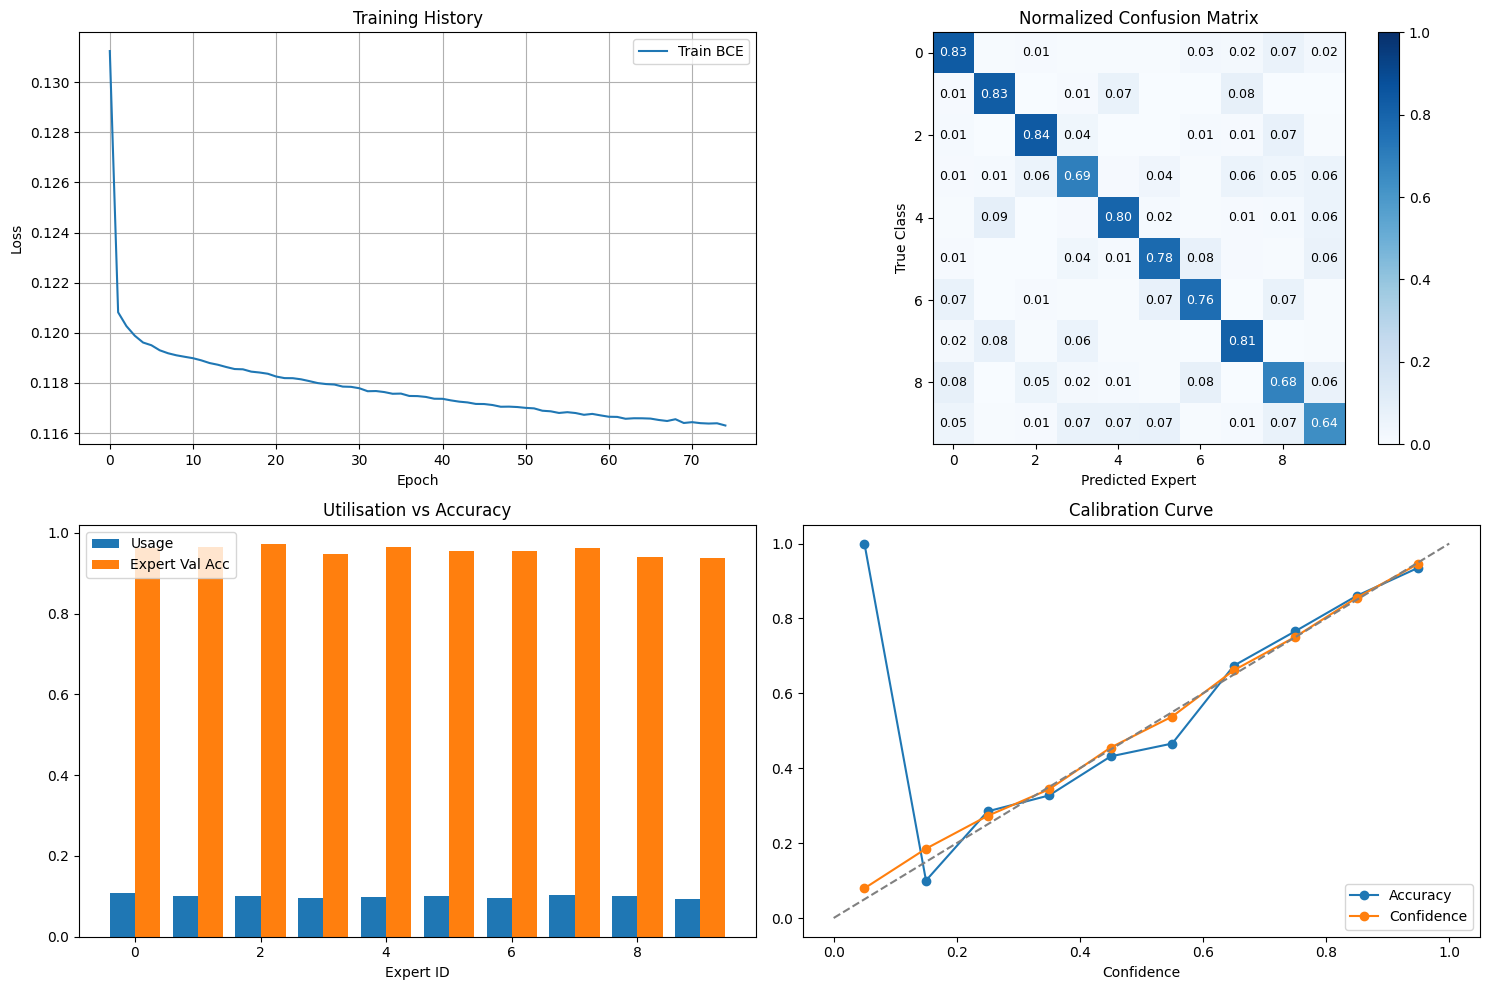

In [15]:
# ───────── VISUALIZATION ────────────────────────────────────────────────────
print("\nGenerating visualizations…")
plt.figure(figsize=(15,10))

# 1) Loss curve
plt.subplot(2,2,1)
plt.plot(train_history, label='Train BCE')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training History')
plt.grid(True); plt.legend()

# 2) Confusion matrix (row-norm)
# plt.subplot(2,2,2)
# conf = results['confusion'].astype(float)
# for i in range(NUM_CLASSES):
#     if results['sample_counts'][i]:
#         conf[i] /= results['sample_counts'][i]
# plt.imshow(conf, cmap='Blues', vmin=0, vmax=1)
# plt.colorbar(); plt.xlabel('Predicted'); plt.ylabel('True')
# plt.title('Normalized Confusion Matrix')
# 2) Confusion matrix (row-norm with annotations)

plt.subplot(2, 2, 2)
conf = results['confusion'].astype(float)
for i in range(NUM_CLASSES):
    if results['sample_counts'][i]:
        conf[i] /= results['sample_counts'][i]

im = plt.imshow(conf, cmap='Blues', vmin=0, vmax=1)
plt.colorbar(im)
plt.xlabel('Predicted Expert')
plt.ylabel('True Class')
plt.title('Normalized Confusion Matrix')

# Annotate each cell with the normalized value
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        val = conf[i, j]
        if val > 0.01:  # Only show non-trivial values
            color = 'white' if val > 0.5 else 'black'
            plt.text(j, i, f"{val:.2f}", ha='center', va='center', color=color, fontsize=9)

# 3) Expert utilisation vs accuracy
plt.subplot(2,2,3)
usage = results['expert_usage'] / total_val
exp_acc = [exp_val_acc[cid].get() for cid in range(NUM_CLASSES)]
x = np.arange(NUM_CLASSES)
plt.bar(x-0.2, usage, width=0.4, label='Usage')
plt.bar(x+0.2, exp_acc, width=0.4, label='Expert Val Acc')
plt.xlabel('Expert ID'); plt.title('Utilisation vs Accuracy'); plt.legend()

# 4) Calibration curve
plt.subplot(2,2,4)
centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
plt.plot(centers, bin_accuracy, 'o-', label='Accuracy')
plt.plot(centers, bin_confidence, 'o-', label='Confidence')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('Confidence'); plt.title('Calibration Curve'); plt.legend()

plt.tight_layout()
plt.savefig('moe_analysis.png', dpi=300)
print(" Analysis complete – plots saved to 'moe_analysis.png'")